<a href="https://colab.research.google.com/github/zzerross/ai/blob/main/rnn/sin/LSTMSinReference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 15ms/step - loss: 0.2438
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1103
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1009
Epoch 4/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0993
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1045
Epoch 6/100
10/10 [==============================] - 0s 17ms/step - loss: 0.1048
Epoch 7/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0935
Epoch 8/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0920
Epoch 9/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0905
Epoch 10/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0922
Epoch 11/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0941
Epoch 12/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0910
Epoch 13/100
10/10 [=================

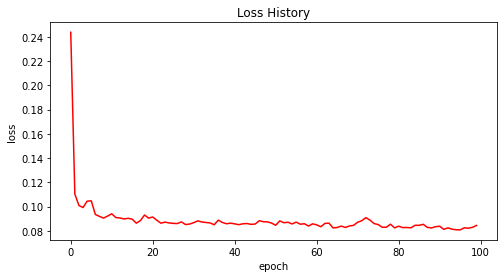

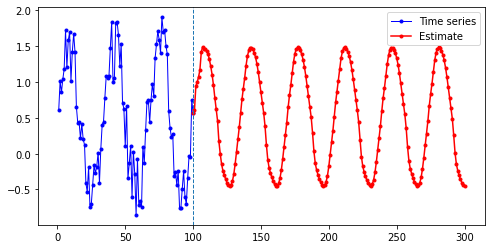

In [2]:
# Refer https://m.blog.naver.com/chunjein/222131850058
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
# 1차원 배열의 시계열 데이터로 학습용 배치 파일을 만든다. 입력값 = 1개, 출력값 = 1개
# return : xBatch - RNN 입력
#          yBatch - RNN 출력
#
# step = 3 인 경우의 예시
# xData = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
# 
# xBatch, yBatch는 3차원 텐서로 만든다. (-1, step=3, 1)
# xBatch = [[1]] [[2]] [[3]] [[4]] [[5]] [[6]] [[7]] --> 7 x 3 x 1
#          [[2]] [[3]] [[4]] [[5]] [[6]] [[7]] [[8]]
#          [[3]] [[4]] [[5]] [[6]] [[7]] [[8]] [[9]]
#
# yBatch =  [4]   [5]   [6]   [7]   [8]   [9]   [10] --> 7 x 1
#
# ex : xBatch[0] = [[3],[4],[5]],   yBatch[0] = [6]
#      3-step 짜리 LSTM에 3,4,5가 입력되면 6이 출력되도록 학습한다.
def createTrainData(xData, step):
    m = np.arange(len(xData) - step)
    x, y = [], []
    for i in m:
        a = xData[i:(i+step)]
        x.append(a)
    xBatch = np.reshape(np.array(x), (len(m), step, 1))
    for i in m+1:
        a = xData[i:(i+step)]
        y.append(a[-1])
    yBatch = np.reshape(np.array(y), (len(m), 1))
    return xBatch, yBatch
# 시계열 데이터 (noisy sin)
data = np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) # trend & noisy sine
nInput = 1
nOutput = 1
nStep = 20
nHidden = 50
# 학습 데이터를 생성한다.
x, y = createTrainData(data, nStep)
# LSTM 모델을 생성한다.
xInput = Input(batch_shape=(None, nStep, 1))
xLstm = LSTM(nHidden)(xInput)
xOutput = Dense(nOutput)(xLstm)
model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer=Adam(lr=0.01))
# 학습한다
h = model.fit(x, y, epochs=100, batch_size=100, shuffle=True)
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
nFuture = 200
if len(data) > 100:
    lastData = np.copy(data[-100:])  # 원 데이터의 마지막 100개만 그려본다
else:
    lastData = np.copy(data)
dx = np.copy(lastData)
estimate = [dx[-1]]
for i in range(nFuture):
    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다
    px = dx[-nStep:].reshape(1, nStep, 1)
    # 다음 값을 예측한다.
    yHat = model.predict(px)[0][0]
    # 예측값을 저장해 둔다
    estimate.append(yHat)
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), yHat)
# Loss history를 그린다
plt.figure(figsize=(8, 4))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
# 원 시계열과 예측된 시계열을 그린다
ax1 = np.arange(1, len(lastData) + 1)
ax2 = np.arange(len(lastData), len(lastData) + len(estimate))
plt.figure(figsize=(8, 4))
plt.plot(ax1, lastData, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimate, 'b-o', color='red', markersize=3, label='Estimate')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()